In [117]:
import os

os.environ["CASTLE_BACKEND"] = "pytorch"
from castle.algorithms import DirectLiNGAM
import pandas as pd
import numpy as np

df = pd.read_csv("dataset.csv")
names = df.columns.to_list()[1:]
data = df.to_numpy()[:, 1:]
data /= data.std(axis=0).reshape(1, -1)

In [118]:
print(names)
print(data.shape)
print(data[:4])

['Mood-0', 'Energy-0', 'Deep_work-0', 'Stoicism-0', 'Optimization_power-0', 'Sleep-0', 'Meditation-0', 'Sport-0', 'Social_interactions-0', 'Mood-1', 'Energy-1', 'Deep_work-1', 'Stoicism-1', 'Optimization_power-1', 'Sleep-1', 'Meditation-1', 'Sport-1', 'Social_interactions-1', 'Mood-2', 'Energy-2', 'Deep_work-2', 'Stoicism-2', 'Optimization_power-2', 'Sleep-2', 'Meditation-2', 'Sport-2', 'Social_interactions-2']
(140, 27)
[[10.557 10.571  1.668  3.114  3.818 12.149  1.807  0.715  1.687  9.272
  10.571  2.497  3.752  2.868 12.15   2.7    0.713  2.535  9.008  8.81
   1.251  3.796  3.824 12.153  1.202  0.714  1.69 ]
 [ 9.237 10.571  2.502  3.737  2.863 12.149  2.711  0.715  2.531  9.272
   9.061  1.249  3.752  3.824 12.15   1.2    0.713  1.69   7.721  8.81
   1.251  3.163  2.868 13.672  1.804  0.178  1.69 ]
 [ 9.237  9.061  1.251  3.737  3.818 12.149  1.205  0.715  1.687  7.948
   9.061  1.249  3.127  2.868 13.669  1.8    0.178  1.69   9.008 10.278
   0.834  3.796  4.779 12.153  1.804  0.3

In [119]:
prior = np.full((len(names), len(names)), fill_value=-1)
for i in range(len(names)):
    for j in range(len(names)):
        if names[i][-1] < names[j][-1]:
            prior[i][j] = 1

solver = DirectLiNGAM(prior_knowledge=prior, thresh=0.1)
solver.learn(data, columns=names)
adj_matrix = solver.weight_causal_matrix

Deep_work -(1)-> Deep_work: 0.4032791100405615
Deep_work -(0)-> Meditation: 0.021900339356322115
Deep_work -(2)-> Mood: 0.13161783398362825
Deep_work -(0)-> Social_interactions: 0.29856860744298025
Deep_work -(1)-> Social_interactions: 0.1072442317446295
Deep_work -(1)-> Stoicism: -0.046209934742893095
Energy -(2)-> Stoicism: -0.08501401455460526
Meditation -(1)-> Meditation: 0.11302870893937525
Meditation -(2)-> Meditation: 0.4252275105471375
Meditation -(1)-> Stoicism: -0.1373565001871791
Mood -(0)-> Energy: 0.11274166330773049
Mood -(0)-> Optimization_power: 0.06342695667678179
Optimization_power -(0)-> Meditation: 0.09213378539179674
Optimization_power -(0)-> Mood: 0.0889551541470089
Sleep -(0)-> Energy: 0.18335049835685524
Sleep -(2)-> Stoicism: 0.02613188486132901
Social_interactions -(0)-> Deep_work: 0.07272796429234418
Social_interactions -(0)-> Stoicism: 0.02662760391682933
Social_interactions -(1)-> Stoicism: -0.044788788168426574
Social_interactions -(2)-> Stoicism: -0.06669

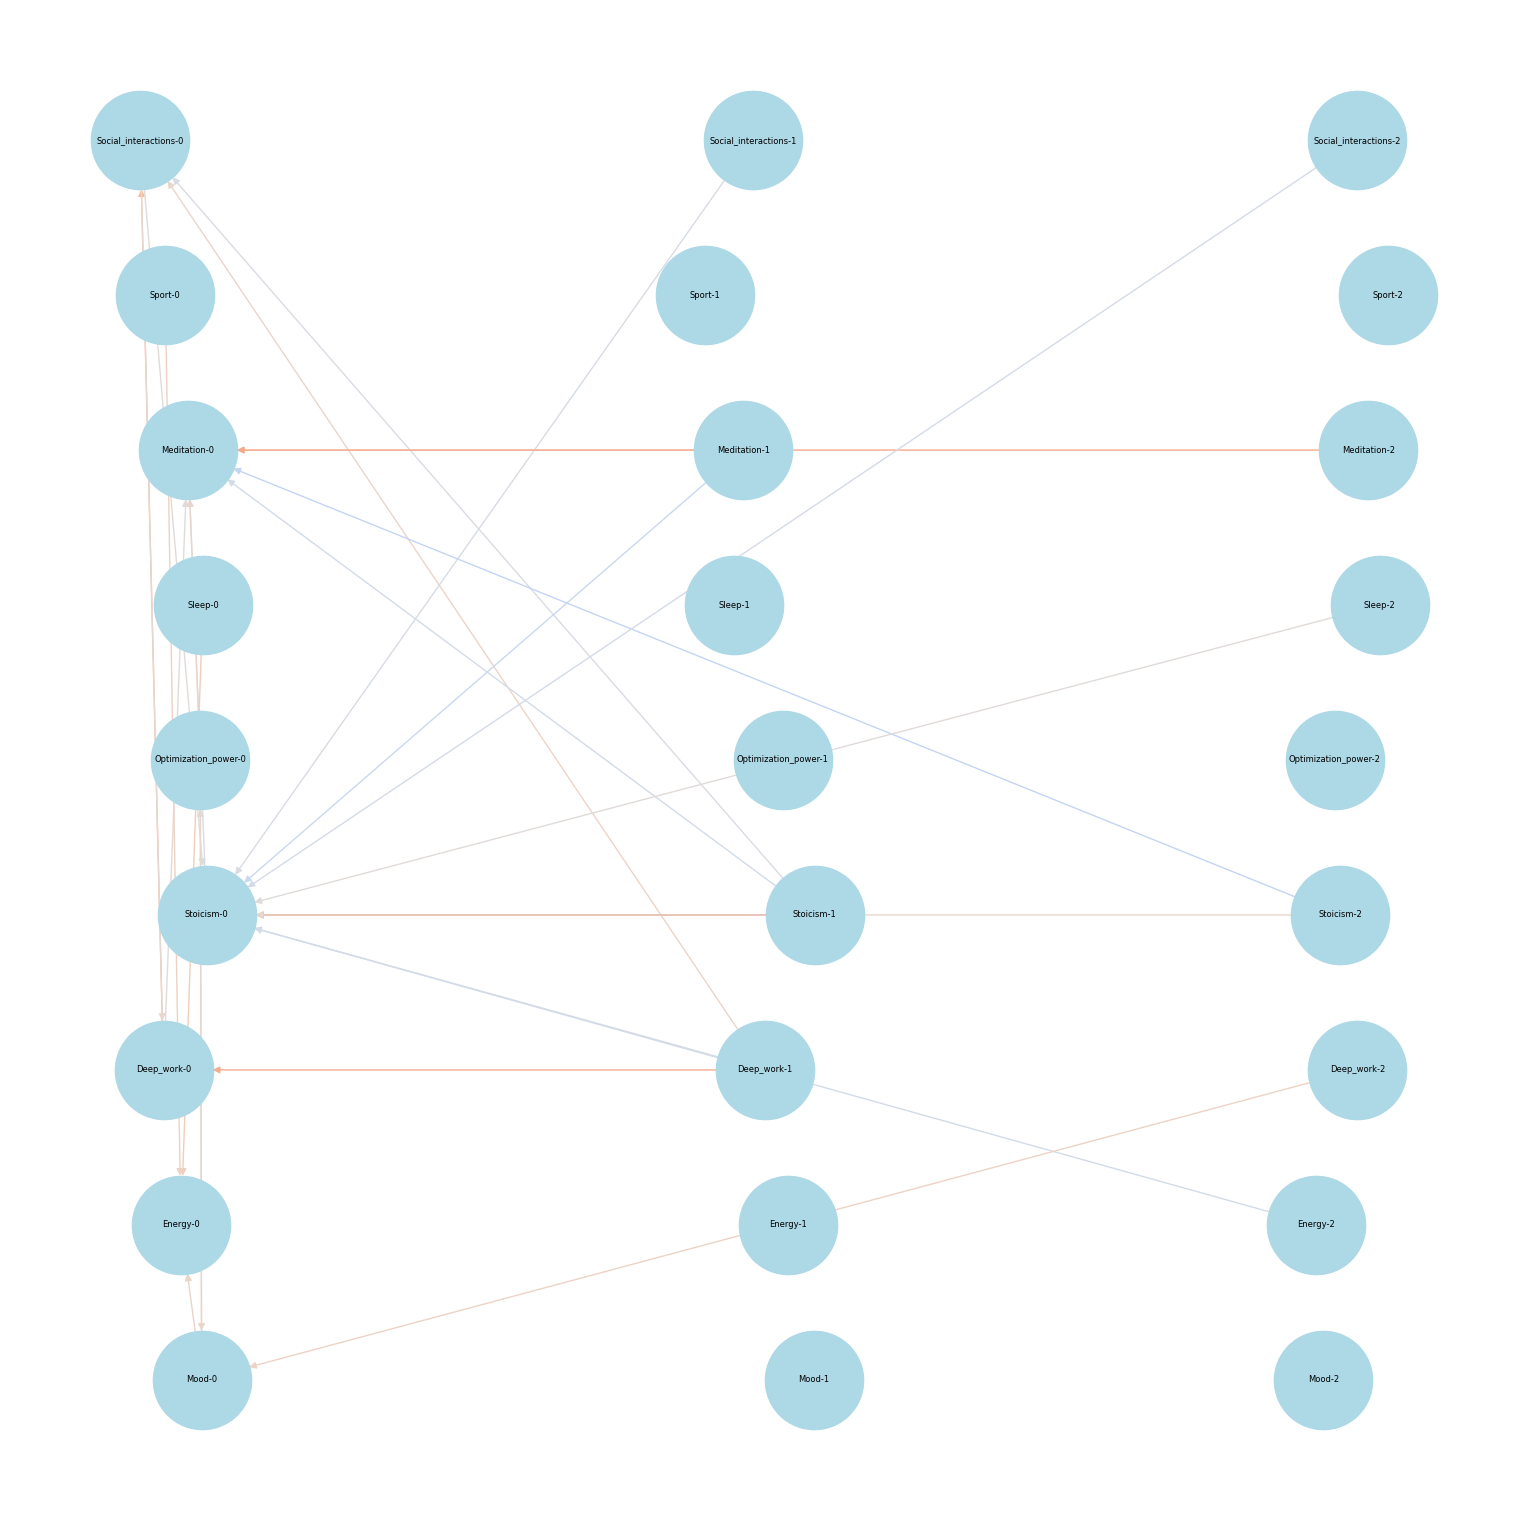

In [120]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict


def number_to_color(number):
    cmap = plt.get_cmap("coolwarm")
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    return cmap(norm(number))


G = nx.DiGraph()

for name in names:
    G.add_node(name)

edge_colors = []
results = []
avg = defaultdict(list)

for i, row in enumerate(adj_matrix):
    for j, value in enumerate(row):
        avg[names[i][:-1], names[j][:-1], int(names[i][-1]) - int(names[j][-1])].append(value)

for (source, target, lag), sizes in avg.items():
    size = (sum(sizes) / len(sizes)) if len(sizes) else 0.0
    if abs(size) > 0.02:
            results.append((source[:-1], target[:-1], lag, size))
            day_j = 0
            v = f"{source}{day_j + lag}"
            u = f"{target}{day_j}"
            color = number_to_color(size)
            edge_colors.append(color)
            G.add_edge(v, u)
results.sort()
for source, target, lag, size in results:
    print(f"{source} -({lag})-> {target}: {size}")
pos = {}
for name in names:
    _, n = name.split("-")
    x = int(n)
    y = sum(round(pos_x) == x for (pos_x, _) in pos.values())
    x += np.random.normal(scale=0.05)
    pos[name] = (x, y)

plt.figure(figsize=(15, 15))
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color="lightblue",
    font_size=6,
    node_size=5000,
    edge_color=edge_colors,
)
# plt.show()
plt.savefig("dag.svg")